# Physical Models: Diffusion
This is our week 7 examples notebook and will be available on Github from the powderflask/cap-comp215 repository.
As usual, the first code block just imports the modules we will use.

In [1]:
%matplotlib inline

import math
import time
from dataclasses import dataclass

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
We're starting to collect some useful re-usable bits of code - we should consider putting these in an importable module...

In [2]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = 'Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step*self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## Simple Diffusion Model
  Diffusion is the net movement of anything (for example, atoms, ions, molecules, energy) generally from a region of higher concentration to a region of lower concentration. [wikipedia](https://en.wikipedia.org/wiki/Diffusion)
Start with an "island" of concentrated "chemical" and simulate its diffusion to areas of lower concentration.

In [4]:
class Diffusion1:
    """ Diffusion CA with a single grids, representing the concentration of a chemical. """

    # Diffuse only to cardinal neighbours
    kernel = np.array([[0,  1, 0],
                       [1, -4, 1 ],
                       [0,  1, 0]])

    def __init__(self, n, r=0.1, initial_concentration=50):
        """ Initializes nxn model with a chemical island near middle with a diffusion rate r """
        self.r = r
        self.vmax = initial_concentration
        self.array = np.zeros((n, n), dtype=float)
        # add an blob of concentrated chemical near centre
        radius = int(n * 0.25)
        i = int(n * 0.5)
        start, end = i-radius, i+radius
        self.array[start:end, start:end] += initial_concentration

    def step(self):
        """ Simulate one time step. """
        c = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
        self.array += self.r * c

    def draw(self, axes=None, step=''):
        """Draws the cells on given axes."""
        axes = axes or plt.gca()  # use current axes if none are provided.
        plot_2D_array(self.array, axes, cmap='Reds', vmin=0, vmax=self.vmax, title=f'Simple Diffusion {step}')

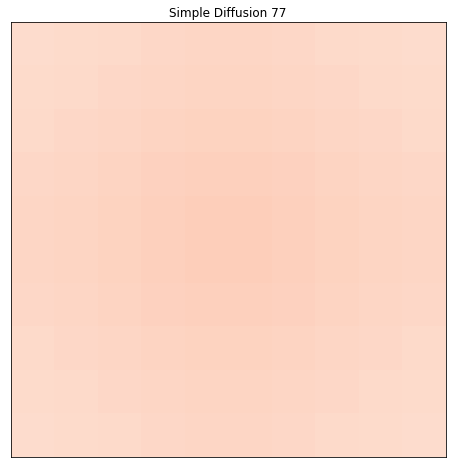

In [25]:
diffusion1 = Animation2D(Diffusion1(n=10), frames=78)
diffusion1.animate()

### A "Chemical" Layer Class
Before things get any more complicated, let's factor out the code that is simply defining initial conditions.
Each "chemical" layer is just a `np.array` with rates defining its diffusion rate and how chemical is intiially distributed.

In [6]:
@dataclass
class Layer:
    """ A layer in the diffusion model with a concentration of chemical, diffusion rate, and feed or kill rate """
    n: int             # layer is an n x n numpy.array
    fill: float = 0    # background fill value for the array
    rate: float = 0.5  # diffusion rate  (0 - 1) for chemical
    # concentrated chemical blob added to initial layer.  Set size=0 for none.
    loc: float = 0.5   # location as a proportion of n where chemical "island" is concentrated
    size: float = 0.05 # size of "island" of chemical as proportion of n, 0 for no island
    height: float = 1  # initial concentration of chemical, where it occurs

    def __post_init__(self):
        self.array = np.full((self.n, self.n), fill_value=self.fill, dtype=float)
        self.add_blob()

    def add_blob(self, loc=None):
        """ Add a concentrated blob of size and height centered on loc in the array."""
        loc = loc or self.loc
        radius = int(self.n * self.size)
        i = int(self.n * loc)
        start, end = i-radius, i+radius
        self.array[start:end, start:end] += self.height

    def __call__(self):
        """ Return a reference to the array representing this layer """
        return self.array


@dataclass
class UniformLayer(Layer):
    """ A uniform layer with same concentration everywhere and no island """
    fill: float = 1
    size: float = 0


@dataclass
class RandomLayer(Layer):
    """ A layer with random concentrations + and island """
    height: float = 0.1

    def __post_init__(self):
        self.array = self.height * np.random.random((self.n, self.n))
        self.add_blob()

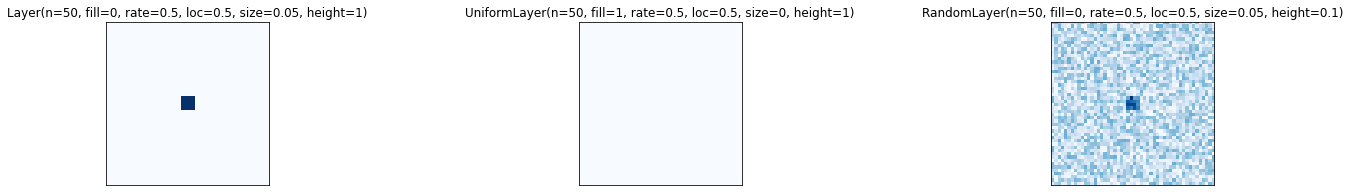

In [7]:
fig, ax = plt.subplots(figsize=(24, 3))
for i, layer in enumerate((Layer(50), UniformLayer(50), RandomLayer(50))):
    plt.subplot(1, 3, i+1)
    plot_2D_array(layer(), title=f'{layer}')

## Reaction-Diffusion
In this model we have 2 "chemicals", each diffusing at their own rate.  When they mix, a chemical "reaction" occurs.
The quantities in each cell of the CA represent "concentration" of a given chemical, between 0 and 1.

For a visual introduction to this model, see [Reaction-Diffusion Tutorial by Karl Sims](https://www.karlsims.com/rd.html)

Following [Sims](https://www.karlsims.com/rd.html):
 * we use a kernel that models lateral and diagonal flows
   the diagnals have lower weights because they are farther from the center cell;

 * the `step` function computes these functions:
   * $\Delta A = r_a \nabla^2 A - AB^2 + f (1-A) $
   * $\Delta B = r_b \nabla^2 B + AB^2 - (k+f) B $
   where $\nabla^2$ is the Laplace operator the kernel is intended to approximate.

We'll build up to this full model in a few steps...

### Step 1:  2-layer diffusion
Just run 2 diffusion models simultaneously on same grid with no interactions.

In [8]:
class Diffusion2:
    """ Diffusion CA with 2 layers, each representing concentration of a different chemical. """

    kernel = np.array([[.05, .2, .05],
                       [.2,  -1, .2 ],
                       [.05, .2, .05]])

    def __init__(self, a, b):
        """ Initialize model with 2 chemical layers, A and B """
        self.layer_A = a
        self.layer_B = b

    def step(self):
        """ Simulate one time step. """
        A, B = self.layer_A(), self.layer_B()

        cA = correlate2d(A, self.kernel, mode='same', boundary='wrap')
        cB = correlate2d(B, self.kernel, mode='same', boundary='wrap')
        A += self.layer_A.rate * cA
        B += self.layer_B.rate * cB

    def simulate(self, n_steps):
        """ Do n steps of the simulation """
        for i in range(n_steps):
            self.step()

    def draw(self, axes=None, step=''):
        """Draws the cells."""
        axes = axes or plt.gca()  # use current axes if none are provided.
        options = dict(interpolation='bicubic', title=f'2-layer Diffusion {step}')
        return (plot_2D_array(self.layer_A(), axes, cmap='Reds', alpha=0.7, **options),
                plot_2D_array(self.layer_B(), axes, cmap='Blues', alpha=0.5, **options))

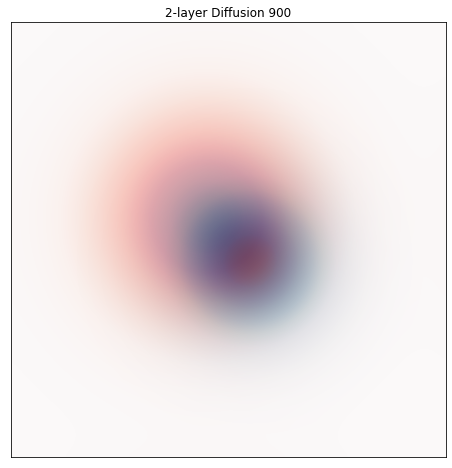

In [9]:
# simple diffusion with 2 layers, different diffusion rates, each with an island near middle
N = 100
model = Diffusion2(
    Layer(n=N, rate=0.5, loc=0.45),
    Layer(n=N, rate=0.25, loc=0.55)
)
diffusion2 = Animation2D(model, frames=10, steps_per_frame=100)
diffusion2.animate()

### Step 2: Add a reaction
When the two chemicals come in contact, a reaction occurs.  A simple type of reaction is that chemical A is consumed to produce more of chemical B

In [10]:
class SimpleReactionDiffusion(Diffusion2):
    """ Diffusion CA with 2 chemicals + a reaction term. """

    def step(self):
        """ Simulate one time step. """
        A, B = self.layer_A(), self.layer_B()

        cA = correlate2d(A, self.kernel, mode='same', boundary='wrap')
        cB = correlate2d(B, self.kernel, mode='same', boundary='wrap')
        # Factor in the reaction term
        reaction = A * B ** 2
        A += self.layer_A.rate * cA - reaction
        B += self.layer_B.rate * cB + reaction

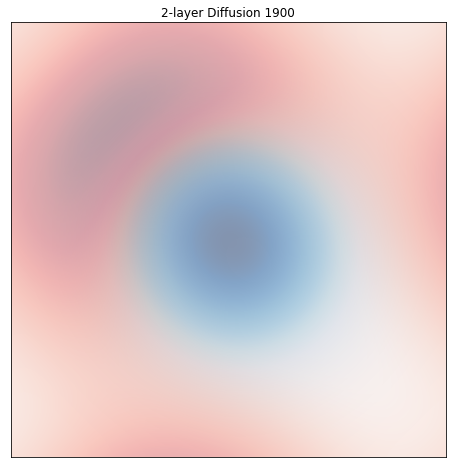

In [11]:
model = SimpleReactionDiffusion(
    Layer(n=N, rate=0.5, loc=0.45),
    Layer(n=N, rate=0.25, loc=0.55)
)
simple_rd = Animation2D(model, frames=20, steps_per_frame=100)
simple_rd.animate()

### Step 3: Add "feed" and "kill" rates
In biological systems, there is often a source for some chemicals (e.g. a gland that produces a hormone) and a sink (e.g., transpiration or absorbtion) for others.
In the final model we "feed" chemical A and "kill" chemical B at rates ``f`` and ``k``, relative to the concentration of A and B, respectively.

In [12]:
class ReactionDiffusion(SimpleReactionDiffusion):
    """ Diffusion CA with 2 chemicals + a reaction term and feed/kill rates. """

    def __init__(self, a, b, feed, kill):
        """ Initialize model with 2 chemical layers, A and B, and feed / kill rates for reaction """
        super().__init__(a, b)
        self.feed = feed
        self.kill = kill

    def step(self):
        """ Simulate one time step. """
        A, B = self.layer_A(), self.layer_B()

        cA = correlate2d(A, self.kernel, mode='same', boundary='wrap')
        cB = correlate2d(B, self.kernel, mode='same', boundary='wrap')
        # Factor in the reaction term and feed / kill terms
        reaction = A * B ** 2
        A += self.layer_A.rate * cA - reaction + self.feed * (1 - A)
        B += self.layer_B.rate * cB + reaction - (self.feed + self.kill) * B

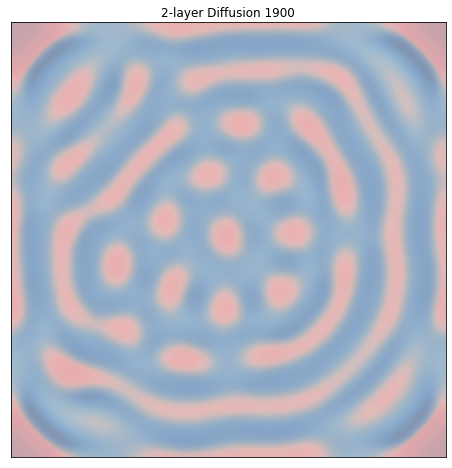

In [13]:
model = ReactionDiffusion(
    UniformLayer(n=N, rate=0.5),
    RandomLayer(n=N, rate=0.25, height=0.1),
    feed=0.035, kill=0.057
)
rd = Animation2D(model, frames=20, steps_per_frame=100)
rd.animate()

## Turing's Conjecture
In his 1952 article, [**_The Chemical Basis of Morphogenesis_**](https://dna.caltech.edu/courses/cs191/paperscs191/turing.pdf), Alan Turning proposed a hypothesis that patterns on animal hides are formed by reaction-diffusion.

This model shows how a very simple reaction-diffusion process can generate a variety of stable patterns...


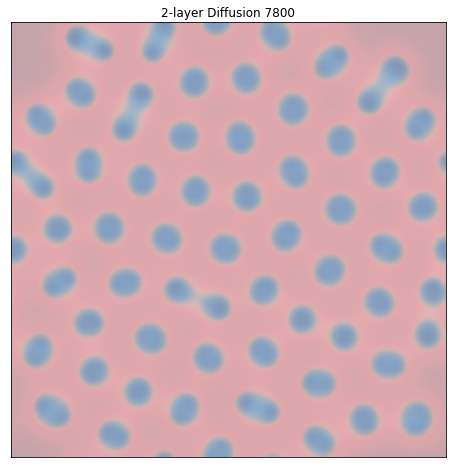

In [27]:
def reaction_diffusion_animation(ra, rb, feed, kill, frames=40, steps_per_frame=200):
    model = ReactionDiffusion(
        UniformLayer(n=N, rate=ra),
        RandomLayer(n=N, rate=rb, height=0.1),
        feed=feed, kill=kill
    )
    return Animation2D(model, frames=frames, steps_per_frame=steps_per_frame)

rules = {
    'stripes': dict(ra=0.5, rb=0.25, feed=0.035, kill=0.057),
    'coral'  : dict(ra=0.5, rb=0.25, feed=0.055, kill=0.062),
    'spots'  : dict(ra=0.5, rb=0.25, feed=0.039, kill=0.065),
    'test'   : dict(ra=0.5, rb=0.25, feed=0.037, kill=0.060),
}

reaction_diffusion_animation(**rules['spots']).animate()

--------------------------------

# Diffusion by "Brownian Motion"

Diffusion is a stochastic process due to the inherent randomness of the diffusing entity and can be used to model many real-life stochastic scenarios. Therefore, diffusion and the corresponding mathematical models has applications in several fields, beyond physics, such as statistics, probability theory, information theory, neural networks, finance and marketing etc. [https://en.wikipedia.org/wiki/Diffusion](https://en.wikipedia.org/wiki/Diffusion)

In the model below, a set of "particles" are placed at the centre of the plane, and then allowed to move using a "random walk".
It is not intuitive that purely random motion like this should result in diffusion, yet it does.

As the length of a random walk tends to zero, it models a "Wiener process", which is a model for Brownian Motion. [https://en.wikipedia.org/wiki/Random_walk](https://en.wikipedia.org/wiki/Random_walk)

### Helpers
Here is the Point2D class we examined earlier...

In [15]:
@dataclass
class Point2D:
    """ A point on the 2D Cartesian plane """
    x: float
    y: float

    def __add__(self, other):
        """ Define the + operator for two points - vector addition """
        return Point2D(self.x + other.x, self.y + other.y)

    @property
    def r(self):
        """ length, r, from origin to this point """
        return math.sqrt(self.x ** 2 + self.y ** 2)

... and a lattice random walk algorithm for Point2D objects...

In [16]:
# N, S, E, W
CARDINAL_NEIGHBOURS = (Point2D(0, 1), Point2D(0, -1), Point2D(1, 0), Point2D(-1, 0))

def random_walk(p):
    """ "walk" point p 1-step, to a neighbouring cardinal locaction (lattice random walk) """
    return p + np.random.choice(CARDINAL_NEIGHBOURS)


In [17]:
class ParticleSimulation:
    """
      Simulates a set of particles (Point2D objects) that all follow the same rule (step function) in each timestep
    """

    def __init__(self, step_fn, n_particles=1, show_paths=False):
        """
        :param step_fn: a function that takes a single Point2D and returns a Point2D representing its next state
        :param n_particles: number of particles to include in simulation
        :param show_paths: True to plot a trace of the path taken by each particle
        """
        self.step_fn = step_fn
        # start set of particles in the origin
        self.particles = [Point2D(0, 0) for _ in range(n_particles)]
        self.radius = 0
        # a path for each particle (i.e., a list of points that a given particel passed through)
        self.show_paths = show_paths
        self.paths = [(p,) for p in self.particles]

    def step(self):
        """ Step the model forward one step """
        self.particles = [self.step_fn(p) for p in self.particles]
        self.radius = max(p.r for p in self.particles)
        self.paths = [path + (p,) for path, p in zip(self.paths, self.particles)]

    def draw(self, axes=None, step=''):
        """ Draw the particles in their current state on the given axes """
        axes = axes or plt.gca()   # use current axes if not supplied
        axes.set_title("Step {step}  Raidus {r}".format(step=step, r=round(self.radius)))

        x, y = [p.x for p in self.particles], [p.y for p in self.particles]
        axes.scatter(x, y, c=list(range(len(x))), cmap='tab20')

        if self.show_paths:
            for path in self.paths:
                x, y = [p.x for p in path], [p.y for p in path]
                axes.plot(x, y)


class ParticleAnimation(Animation2D):
    """
      Animates a ParticleSimulation where we want to fix the axes coordinates for all frames of the animation
    """

    def __init__(self, model, frames=50, axes_range=None, figsize=(8, 8)):
        """
        :param model: the ParticleSimulation object to animate
        :param frames: number of animation frames to generate
        :param axes_range: optional 2-tuple with (min, max) range for axes
        """
        super().__init__(model, frames, figsize=figsize)
        self.axes_range = axes_range or (-frames // 2, frames // 2)  # particles will diffuse over wider area as animation goes on longer

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        self.ax.clear()
        # fix the axes limits so they don't autoscale as particles diffuse
        self.ax.set_ylim(*self.axes_range)
        self.ax.set_xlim(*self.axes_range)

        super().animation_step(step)

In [19]:
# Animate a collection of random walking particles...
n_particles = 100
frames = 50
show_paths = True

model = ParticleSimulation(random_walk, n_particles, show_paths=show_paths)
anim = ParticleAnimation(model, frames=frames, axes_range=(-15, 15))
anim.show()